In [11]:
'''
    Author:  Varnit Singh
    Date:    7/7/2024
    Purpose: Market Risk Assessment Using Deep Learning Model
    Github: https://github.com/varnit-ta
'''

'\n    Author:  Varnit Singh\n    Date:    7/7/2024\n    Purpose: Market Risk Assessment Using Deep Learning Model\n    Github: https://github.com/varnit-ta\n'

## Training and Evaluating the model

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [13]:
'''
    Load the data and preprocess it
'''

# Load the data
data = pd.read_csv('data.csv')

# Define features and target
features = ['Volatility', 'Beta', 'Market Cap', 'P/E Ratio', 'Dividend Yield', 'Current Ratio', '52 Week High', '52 Week Low']
target = 'Risk Percentage'

data = data.dropna(subset=[target])

missing_counts = data[features].isnull().sum(axis=1)

filtered_data = data[missing_counts <= 4]

# Separate features and target
X = filtered_data[features].values
y = filtered_data[target].values

X = np.where(np.isfinite(X), X, np.nan)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

scaler = RobustScaler()
X = scaler.fit_transform(X)

print("Filtered and preprocessed data:")
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Filtered and preprocessed data:
Features shape: (793, 8)
Target shape: (793,)


In [14]:
'''
    Split the data into training and testing sets
    then convert them to PyTorch tensors
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [15]:
'''
    Defining the hyperparameters for the model
    input_size: Number of features
    hidden_size: Number of neurons in the hidden layer
    num_layers: Number of hidden layers
    output_size: Number of output neurons
    dropout_rate: Dropout rate for regularization
    learning_rate: Learning rate for the optimizer
    num_epochs: Number of epochs for training
    batch_size: Number of samples in each batch
'''

input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 1
dropout_rate = 0.3
learning_rate = 0.001
num_epochs = 300
batch_size = 32

In [16]:
'''
    Data Loader for training the model
    train_dataset: TensorDataset containing training data
    train_loader: DataLoader for the training dataset
'''

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
'''
    Define the LSTM model
    The model consists of an LSTM layer followed by two fully connected layers
    The model uses ReLU activation function and dropout for regularization
    The model also uses batch normalization to normalize the output of the LSTM layer

    Args:
        input_size: Number of features
        hidden_size: Number of hidden layers
        num_layers: Number of layers
        output_size: Number of outputs
        dropout_rate: Dropout rate
'''

class MarketRiskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super(MarketRiskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.relu(out[:, -1, :])
        out = self.dropout(out)
        out = self.batch_norm(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
'''
    Initialize the model, loss function and optimizer
'''

model = MarketRiskLSTM(input_size, hidden_size, output_size, num_layers, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
'''
    Learning rate scheduler
'''

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

In [20]:
'''
    Training and testing the model using early stopping
    The model is saved if the testing loss improves
    The model stops training if there is no improvement in the testing loss for a number of epochs
    
    Args:
        num_epochs: Number of epochs
        patience: Number of epochs to wait before stopping
        best_loss: Best loss value
        no_improve: Number of epochs with no improvement
        train_losses: Training losses
        test_losses: Testing losses
    Returns:
        Trained model
'''

best_loss = float('inf')
patience = 20
no_improve = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X.unsqueeze(1))
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test.unsqueeze(1))
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    scheduler.step(test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        no_improve = 0
        torch.save(model.state_dict(), 'market_risk_lstm.pth')
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch+1) % 10 == 0:
        print("="*80)
        print("Epoch [{}/{}]".format(epoch+1, num_epochs))
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print("="*80)

Epoch [10/300]
Train Loss: 290.3258
Test Loss: 161.1856
Epoch [20/300]
Train Loss: 98.7916
Test Loss: 45.6117
Epoch [30/300]
Train Loss: 43.6135
Test Loss: 12.4691
Epoch [40/300]
Train Loss: 34.6482
Test Loss: 12.2008
Epoch [50/300]
Train Loss: 30.2523
Test Loss: 11.0146
Epoch [60/300]
Train Loss: 22.8357
Test Loss: 10.9071
Epoch [70/300]
Train Loss: 23.7542
Test Loss: 11.1680
Epoch [80/300]
Train Loss: 16.5446
Test Loss: 10.8029
Epoch [90/300]
Train Loss: 17.4608
Test Loss: 10.5319
Epoch [100/300]
Train Loss: 17.2197
Test Loss: 10.6447
Epoch [110/300]
Train Loss: 15.6259
Test Loss: 10.6203
Epoch [120/300]
Train Loss: 13.8584
Test Loss: 10.1785
Early stopping at epoch 123


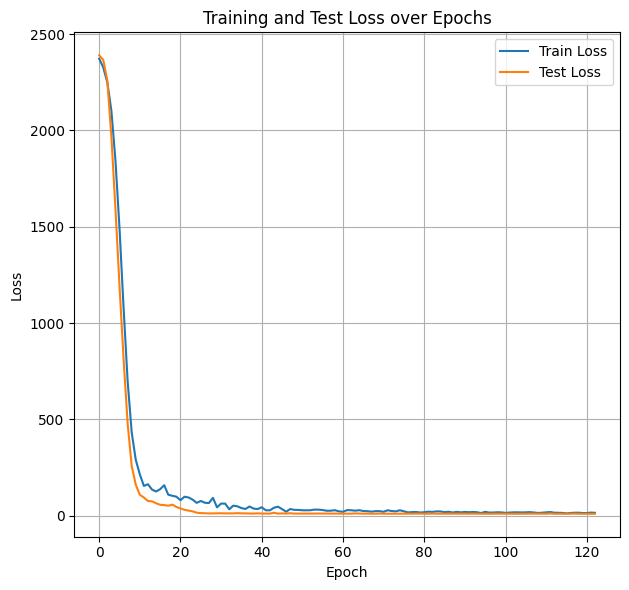

In [21]:
'''
    Plot the training and testing losses over epochs
'''

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
'''
    Save the model to a file
'''

torch.save(model.state_dict(), 'market_risk_lstm.pth')

## Using the Model by the users

In [23]:
model_path = 'market_risk_lstm.pth'

In [24]:
def preprocess_input(data, scaler):
    imputer = SimpleImputer(strategy='mean')
    data = imputer.fit_transform(data)
    
    data = scaler.transform(data)
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [25]:
'''
    Transfer the model state dict to the new model
    
    Args:
        model: New model
        state_dict: Model state dict
    Returns:
        New model with transferred state dict
'''

model = MarketRiskLSTM(input_size, hidden_size=hidden_size, output_size=1, num_layers=num_layers, dropout_rate=dropout_rate)
state_dict = torch.load(model_path, map_location=torch.device('cuda'))

In [26]:
'''
    Handle different model architectures by transferring compatible layers
    
    Args:
        model: New model
        state_dict: Model state dict
    Returns:
        New model with transferred state dict
'''

model_state_dict = model.state_dict()
for name, param in state_dict.items():
    if name in model_state_dict:
        if param.shape == model_state_dict[name].shape:
            model_state_dict[name] = param

In [28]:
'''
    Load the transferred state dict to the new model
'''

model.load_state_dict(torch.load('market_risk_lstm.pth'))
model.eval()

MarketRiskLSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [29]:
'''
    User input for prediction
    
    Args:
        features: List of features
    Returns:
        User input values
'''

print("Enter values for the following features:")
user_input = []
for feature in features:
    value = float(input(f"{feature}: "))
    user_input.append(value)

Enter values for the following features:


In [30]:
'''
    Preprocess the user input for prediction
    
    Args:
        user_input: User input values
        scaler: MinMaxScaler object
    Returns:
        Processed user input
'''

user_input = pd.DataFrame([user_input], columns=features)
user_input_processed = preprocess_input(user_input.values, scaler)

In [31]:
'''
    Predict the risk percentage
    
    Args:
        user_input_processed: Processed user input
    Returns:
        Predicted risk percentage
'''

with torch.no_grad():
    output = model(user_input_processed.unsqueeze(0)).item()

print(f"\nPredicted Risk Percentage: {output:.2f}")


Predicted Risk Percentage: 48.78
